# Homework01: Multiclass classification using PCA/ Logistic regression

## Multi-class Logistic Regression

In [1]:
import pandas as pd
import sklearn
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn.decomposition import PCA

### Loading the data

In [2]:
dataset=datasets.fetch_olivetti_faces()
X=dataset.data
y=dataset.target

### Visualizing the training set

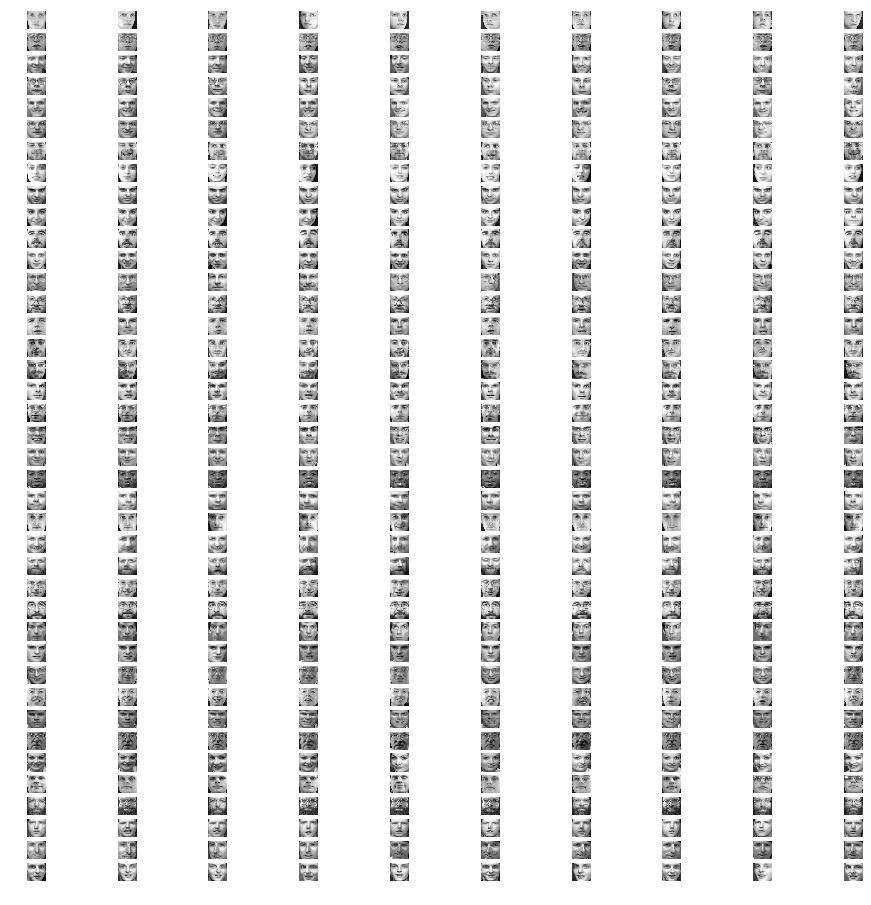

In [3]:
import matplotlib.image as mpimg
fig, axis = plt.subplots(40,10,figsize=(16,16))
for i in range(40):
    for j in range(10):
        axis[i,j].imshow(X[10*i+j,:].reshape(64,64), cmap="gray")
        axis[i,j].axis("off")

## Visualizing the eigen-vector of covariance matrix

(27, 4096)


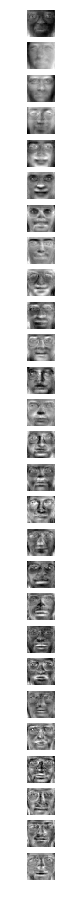

In [4]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.25,random_state=42)
pca = PCA(n_components=0.8, svd_solver='full',whiten=True).fit(x_train)
print(pca.components_.shape)
fig, axis = plt.subplots(pca.components_.shape[0],1,figsize=(16,16))
for i in range(pca.components_.shape[0]):
    axis[i].imshow(pca.components_[i,:].reshape(64,64), cmap="gray")
    axis[i].axis("off")

In [5]:
x_train_pca=pca.transform(x_train)
x_test_pca=pca.transform(x_test)
y_train=y_train.reshape((-1,1))
y_test=y_test.reshape((-1,1))
print(x_train_pca.shape,x_test_pca.shape)

(300, 27) (100, 27)


### Computing the Cost Function


$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$

In [6]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    return 1/ (1 + np.exp(-z))

In [7]:
def lrCostFunction(theta, X, y, Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    m=y.shape[0]
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0= 1/m * (X.T @ (predictions - y))[0]
    j_1 = 1/m * (X.T @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[np.newaxis,:],j_1))
    return regCost[0], grad

### One-vs-all Classification

In [8]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = lrCostFunction(theta,X,y,Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta , J_history

In [9]:
def oneVsAll(X, y, num_labels, Lambda,nIterations):
    """
    Takes in numpy array of X,y, int num_labels and float lambda to train multiple logistic regression classifiers
    depending on the number of num_labels using gradient descent. 
    
    Returns a matrix of theta, where the i-th row corresponds to the classifier for label i
    """
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J=[]
    # add intercept terms
    
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1,num_labels+1):
        print("Training one-vs-rest classifier number",i)
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,0.5,nIterations,Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels,n+1), all_J

In [10]:
all_theta, all_J = oneVsAll(x_train_pca, y_train, 40,0,300)

Training one-vs-rest classifier number 1
Training one-vs-rest classifier number 2
Training one-vs-rest classifier number 3
Training one-vs-rest classifier number 4
Training one-vs-rest classifier number 5
Training one-vs-rest classifier number 6
Training one-vs-rest classifier number 7
Training one-vs-rest classifier number 8
Training one-vs-rest classifier number 9
Training one-vs-rest classifier number 10
Training one-vs-rest classifier number 11
Training one-vs-rest classifier number 12
Training one-vs-rest classifier number 13
Training one-vs-rest classifier number 14
Training one-vs-rest classifier number 15
Training one-vs-rest classifier number 16
Training one-vs-rest classifier number 17
Training one-vs-rest classifier number 18
Training one-vs-rest classifier number 19
Training one-vs-rest classifier number 20
Training one-vs-rest classifier number 21
Training one-vs-rest classifier number 22
Training one-vs-rest classifier number 23
Training one-vs-rest classifier number 24
T

### Plotting of Cost function

Text(0.5, 1.0, 'Cost function using Gradient Descent for classifier 1')

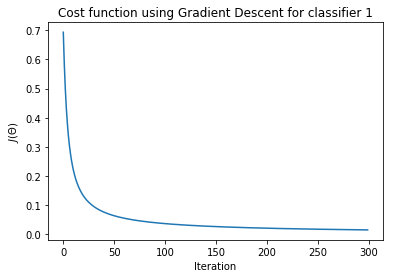

In [11]:
#Cost function for classifier 1
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent for classifier 1")

### One-vs-all Prediction

In [12]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of X(i) for each class and predict the label
    
    return a vector of prediction
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)+1

In [13]:
pred_train = predictOneVsAll(all_theta, x_train_pca)
print("Training Set Accuracy:",sum(pred_train[:,np.newaxis]==y_train)[0]/pred_train.shape[0]*100,"%")
pred_test=predictOneVsAll(all_theta, x_test_pca)
print("Test Set Accuracy:",sum(pred_test[:,np.newaxis]==y_test)[0]/pred_test.shape[0]*100,"%")


Training Set Accuracy: 97.66666666666667 %
Test Set Accuracy: 91.0 %
